In [1]:
# 使用Tab自动补全代码
%config IPCompleter.greedy=True

# 线性规划(pulp实现)

题目和代码均来自[【数学建模】线性规划各种问题的Python调包方法](https://www.jianshu.com/p/9be417cbfebb)，代码看完文章后自己敲了一遍，然后对了下，自己实现的还是比较一般

**简单线性规划**

1.设变量$x,y$满足约束条件$
z = 
\begin{cases} 
2x - y \leq 2 \\
x - y \geq -1 \\
x + y \geq 1
\end{cases}
$，则$z = 2x + 3y$的最大值是多少？

In [2]:
import pulp as lp
# 目标函数和约束条件的系数
z = [2,3]
a = [[1,-1],[1,1],[2,-1]]
b = [-1,1,2]
# 第一步实例化LpProblem，'name'为优化问题的命名，sense=pulp.LpMaximize/pulp.LpMinimize为所求问题类型
PB = lp.LpProblem('maxZ',sense=lp.LpMaximize)
# 第二步声明决策变量分别是x1，x2，x3......xn
x = [lp.LpVariable(f'x{i}',lowBound=0) for i in range(1,3)]
# 第三步将目标函数和约束条件分别传入PB，这里用到了lpDot方法，相当于用系数向量(行)乘以变量向量(列)
PB += lp.lpDot(z,x)
for i in range(len(a)-1):
    PB += (lp.lpDot(a[i], x) >= b[i])
PB += (lp.lpDot(a[2],x) <= b[2])
# 求解
PB.solve()
# 输出结果
print(f'优化结果：{lp.value(PB.objective)}')
print(f'变量取值：{[lp.value(var) for var in x]}')

1

优化结果：18.0
变量取值：[3.0, 4.0]


**运输问题**

2.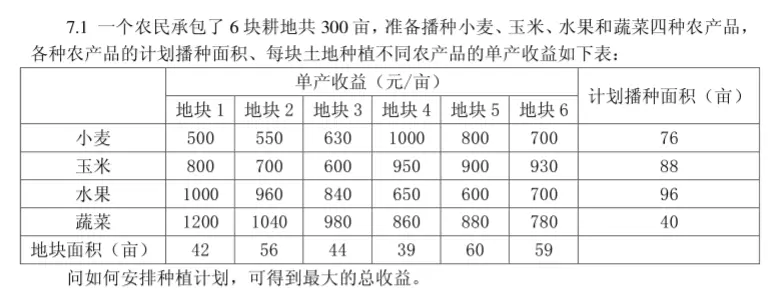

In [3]:
import pulp as lp
import numpy as np
from pprint import pprint
def pro_max(profit,I,J):
    
    row = len(profit)
    col = len(profit[0])
    flatten = lambda x: [y for l in x for y in flatten(l)] if type(x) is list else [x]
    
#     第一步
    prob = lp.LpProblem('Plant Plan',sense=lp.LpMaximize)
#     第二步
    X = [[lp.LpVariable(f'x{i}{j}',lowBound=0) for j in range(col)] for i in range(row)]
#     第三步
    prob += lp.lpDot(profit.flatten(),flatten(X))
#     正确写法
    for i in range(row):
        prob += (lp.lpSum(X[i]) <= I[i])
    for j in range(col):
        prob += (lp.lpSum([(X[i][j]) for i in range(row)]) <= J[j])
#     错误写法
#     prob += ([lp.lpSum(X[i]) for i in range(row)] <= I)
#     prob += ([lp.lpSum([(X[i][j]) for j in range(col) for i in range(row)])] <= J)
    
    prob.solve()
    return {'objective':lp.value(prob.objective), 'variable': [[lp.value(X[i][j]) for j in range(col)] for i in range(row)]}

In [4]:
if __name__ == '__main__':
    profit = np.array([
        [500,550,630,1000,800,700],
        [800,700,600,950,900,930],
        [1000,960,840,650,600,700],
        [1200,1040,980,860,880,780]
    ])
    I = [76,88,96,40]
    J = [42,56,44,39,60,59]
    result = pro_max(profit,I,J)
    print(f'优化结果：{result["objective"]}')
    print('参数取值：')
    pprint(result['variable'])

优化结果：284230.0
参数取值：
[[0.0, 0.0, 6.0, 39.0, 31.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 29.0, 59.0],
 [2.0, 56.0, 38.0, 0.0, 0.0, 0.0],
 [40.0, 0.0, 0.0, 0.0, 0.0, 0.0]]


In [5]:
# 备注
# flatten = lambda x: [y for l in x for y in flatten(l)] if type(x) is list else [x] 的等价形式
import numpy as np

flatten = lambda x: [y for l in x for y in flatten(l)] if type(x) is list else [x]

A = np.array([[1,2],[3,4],[5,6]])
B = [[1,2],[3,4],[5,6]]

print(flatten(A))
print(flatten(B))

def my_flatten(x):
    if type(x) is list:
        Y = []
        for l in x:
            for y in my_flatten(l):
                Y.append(y)
        return Y
    else:
        return [x]

print(my_flatten(A))
print(my_flatten(B))

[array([[1, 2],
       [3, 4],
       [5, 6]])]
[1, 2, 3, 4, 5, 6]
[array([[1, 2],
       [3, 4],
       [5, 6]])]
[1, 2, 3, 4, 5, 6]


**指派问题**

3.拟分配 $n$ 人去干项 $n$ 工作，每人干且仅干一项工作，若分配第 $i$ 人去干第 $j$ 项工作，需花费 $c_ij$ 单位时间，问应如何分配工作才能使公认花费的总时间最少？
假设指派问题的系数矩阵为

引入变量 $x_ij$ ，若分配 $i$ 干 $j$ 工作，则取 $x_ij = 1$ ，否则取 $x_ij = 0$ ，上述指派问题的数学模型为

指派问题的可行解用矩阵表示，每行每列有且只有一个元素为1，其余元素均为0

In [6]:
import pulp as lp
import numpy as np
from pprint import pprint
def time_min(C):
    
    row = len(C)
    col = len(C[0])
    flatten = lambda x: [y for l in x for y in flatten(l)] if type(x) is list else [x]

#     第一步
    prob = lp.LpProblem('Assignment_Problem',sense=lp.LpMinimize)
#     第二步
    X = [[lp.LpVariable(f'x{i}{j}',cat=lp.LpBinary) for j in range(col)] for i in range(row)]
#     第三步
    prob += lp.lpDot(C.flatten(),flatten(X))
    for i in range(row):
        prob += (lp.lpSum(X[i]) == 1)
    for j in range(col):
        prob += (lp.lpSum([(X[i][j]) for i in range(row)]) == 1)
    
    prob.solve()
    
    print(prob)
    
    return {'objective':lp.value(prob.objective), 'variable': [[lp.value(X[i][j]) for j in range(col)] for i in range(row)]}

In [7]:
if __name__ == '__main__':
    C = np.array([
    [12, 7, 9, 7, 9],
    [8, 9, 6, 6, 6],
    [7, 17, 12, 14, 9],
    [15, 14, 6, 6, 10],
    [4, 10, 7, 10, 9]
])
    result = time_min(C)
    
    print(f'优化结果：{result["objective"]}')
    print('参数取值：')
    pprint(result['variable'])

Assignment_Problem:
MINIMIZE
12*x00 + 7*x01 + 9*x02 + 7*x03 + 9*x04 + 8*x10 + 9*x11 + 6*x12 + 6*x13 + 6*x14 + 7*x20 + 17*x21 + 12*x22 + 14*x23 + 9*x24 + 15*x30 + 14*x31 + 6*x32 + 6*x33 + 10*x34 + 4*x40 + 10*x41 + 7*x42 + 10*x43 + 9*x44 + 0
SUBJECT TO
_C1: x00 + x01 + x02 + x03 + x04 = 1

_C2: x10 + x11 + x12 + x13 + x14 = 1

_C3: x20 + x21 + x22 + x23 + x24 = 1

_C4: x30 + x31 + x32 + x33 + x34 = 1

_C5: x40 + x41 + x42 + x43 + x44 = 1

_C6: x00 + x10 + x20 + x30 + x40 = 1

_C7: x01 + x11 + x21 + x31 + x41 = 1

_C8: x02 + x12 + x22 + x32 + x42 = 1

_C9: x03 + x13 + x23 + x33 + x43 = 1

_C10: x04 + x14 + x24 + x34 + x44 = 1

VARIABLES
0 <= x00 <= 1 Integer
0 <= x01 <= 1 Integer
0 <= x02 <= 1 Integer
0 <= x03 <= 1 Integer
0 <= x04 <= 1 Integer
0 <= x10 <= 1 Integer
0 <= x11 <= 1 Integer
0 <= x12 <= 1 Integer
0 <= x13 <= 1 Integer
0 <= x14 <= 1 Integer
0 <= x20 <= 1 Integer
0 <= x21 <= 1 Integer
0 <= x22 <= 1 Integer
0 <= x23 <= 1 Integer
0 <= x24 <= 1 Integer
0 <= x30 <= 1 Integer
0 <= x

# 最后感谢一波dalao：[crossous](https://www.jianshu.com/u/50094e11ed08)